In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.losses import *

In [54]:
def SMAPE(y_true, y_pred):
    N = tf.cast(tf.shape(y_true, out_type=tf.int32)[-1], dtype=tf.float32)
    t1 = tf.math.pow(tf.math.abs(tf.math.subtract(y_pred, y_true)), tf.constant(2.0, dtype=tf.float32))
    t2 = tf.math.minimum( tf.math.multiply(tf.constant(2.0, dtype=tf.float32),tf.math.abs(y_true)), tf.math.abs(y_pred))
    t3 = tf.math.pow(tf.math.add(t2, tf.math.abs(y_true)), tf.constant(2.0, dtype=tf.float32))
    t4 = tf.math.divide(t1, t3)
    m = tf.math.multiply(tf.math.divide(tf.constant(100.0,dtype=tf.float32), N), t4)
    res = tf.math.subtract(tf.constant(100.0,dtype=tf.float32), m)
    return res

def test_SMAPE(y_true, y_pred):
    score = 100
    val = 0
    for i in range(y_true.shape[0]):
        val += abs(y_pred[i]-y_true[i])**2/(min(2*abs(y_true[i]),abs(y_pred[i])) + abs(y_true[i]) )**2
    score -= (100/y_true.shape[0])*val
    return score

In [55]:
def get_nn_model_1(lr=6e-3, amsgrad=True, n_feature=3, l2_kernel=0.01, l1_act=0.01, decay=0.001):
    adam = Adam(lr=lr,amsgrad=amsgrad, decay=decay)
    model = Sequential()
    model.add(Dense(1024, input_shape=(n_feature,), kernel_regularizer=tf.keras.regularizers.l2(l2_kernel), \
                    activity_regularizer=tf.keras.regularizers.l1(l1_act)))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.add(LeakyReLU())
    model.compile(loss='mse', optimizer=adam, metrics=[SMAPE])
    model.build()
    model.summary()
    return model
model = get_nn_model_1(n_feature=7)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 1024)              8192      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_36 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 512)               2048      
_________________________________________________________________
dense_37 (Dense)             (None, 256)              

In [56]:
norm_df = pd.read_csv('norm_data_df.csv')
train_df = pd.read_csv('train.csv')

In [57]:
whole_df = pd.merge(norm_df, train_df, on='id', how='inner')

# random data
train_set = whole_df.sample(frac=0.80, random_state=0)
test_set = whole_df.drop(train_set.index)

train_set.head()

,id,gender,ocp_cd,age,cc_txn_amt,cc_count,kp_txn_count,kp_txn_amt,income
11841,11842,2,9.0,3,3.662758,5.0,39.0,5.348500,28000
19602,19603,1,4.0,4,5.436799,97.0,0.0,0.000000,65000
45519,45520,2,3.0,4,4.017033,13.0,0.0,0.000000,21000
25747,25748,1,9.0,5,0.000000,0.0,0.0,0.000000,33000
42642,42643,2,4.0,3,6.167376,230.0,228.0,6.683263,95000


In [63]:
def df2np(df):
    if 'id' in df.columns:
        df = df.drop('id', axis=1)
   
    y = None
    if 'income' in df.columns:
        y = df['income'].to_numpy()
        df = df.drop('income', axis=1)
    x = df.to_numpy()
    return x, y

In [59]:
x_train, y_train = df2np(train_set)
x_test, y_test = df2np(test_set)

In [40]:
hist = model.fit(x=x_train,y=y_train, epochs=200, initial_epoch=150, batch_size=256, shuffle=True,validation_data=(x_test, y_test), verbose=1)
# _y = model.predict(x_test)
#     print('test_SMAPE:',test_SMAPE(y_test, _y))

Train on 39991 samples, validate on 9998 samples
Epoch 151/200
39991/39991 [==============================] - 6s 140us/sample - loss: 2054059921.8952 - SMAPE: 88.6594 - val_loss: 2031437461.5339 - val_SMAPE: 89.6163
Epoch 152/200
39991/39991 [==============================] - 5s 136us/sample - loss: 2052555899.1925 - SMAPE: 88.6105 - val_loss: 2030653689.9060 - val_SMAPE: 89.7966
Epoch 153/200
39991/39991 [==============================] - 6s 139us/sample - loss: 2051212324.4594 - SMAPE: 88.7614 - val_loss: 2026644088.2416 - val_SMAPE: 89.4801
Epoch 154/200
39991/39991 [==============================] - 6s 142us/sample - loss: 2047454822.8775 - SMAPE: 88.7675 - val_loss: 2010683658.9590 - val_SMAPE: 89.1125
Epoch 155/200
39991/39991 [==============================] - 6s 145us/sample - loss: 2046455890.3353 - SMAPE: 88.6646 - val_loss: 2021033979.6471 - val_SMAPE: 89.8495
Epoch 156/200
39991/39991 [==============================] - 6s 141us/sample - loss: 2042412361.5077 - SMAPE: 88.768

Epoch 200/200
39991/39991 [==============================] - 6s 158us/sample - loss: 2017013945.5393 - SMAPE: 88.5292 - val_loss: 2070670422.5453 - val_SMAPE: 89.2600


In [41]:
# model.save_weights('./weights/too_model.hdf5')

In [42]:
loss,val_loss, score,val_score = hist.history['loss'],hist.history['val_loss'], hist.history['SMAPE'], hist.history['val_SMAPE']

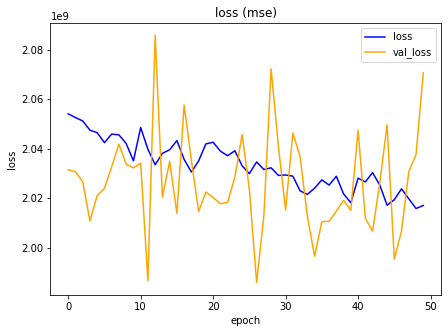

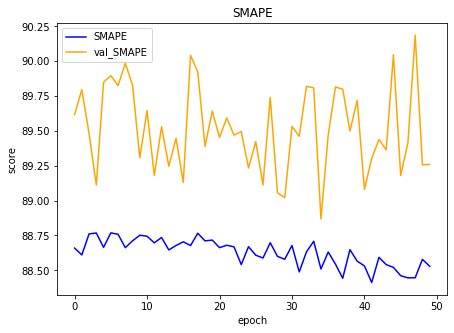

In [43]:
plt.figure(figsize=(7,5))
plt.title('loss (mse)')
plt.plot(np.arange(len(loss)),loss,label='loss',color='blue')
plt.plot(np.arange(len(val_loss)),val_loss,label='val_loss',color='orange')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('SMAPE')
plt.plot(np.arange(len(score)),score,label='SMAPE',color='blue')
plt.plot(np.arange(len(val_score)),val_score,label='val_SMAPE',color='orange')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()
plt.show()

In [60]:
test_df = pd.read_csv('test.csv')
norm_test_df = pd.merge(test_df, norm_df, on='id', how='inner')
norm_test_df

,id,gender,ocp_cd,age,cc_txn_amt,cc_count,kp_txn_count,kp_txn_amt
0,50001,1,9.0,3,4.502427,7.0,28.0,4.810233
1,50002,1,9.0,4,3.770852,2.0,131.0,4.971740
2,50003,1,3.0,4,0.000000,0.0,83.0,5.306425
3,50004,2,3.0,4,3.857332,9.0,20.0,4.041393
4,50005,1,3.0,4,4.170262,7.0,67.0,5.291147
...,...,...,...,...,...,...,...,...
14995,64996,2,3.0,2,0.000000,0.0,20.0,4.614897
14996,64997,2,3.0,2,3.322219,1.0,76.0,5.303628
14997,64998,1,9.0,3,0.000000,0.0,92.0,5.209515
14998,64999,2,3.0,3,4.371068,18.0,106.0,5.694430


In [66]:
x_test, _ = df2np(norm_test_df)

In [67]:
model.load_weights('./weights/too_model.hdf5')

In [68]:
y_pred = model.predict(x_test)
y_pred

array([[25170.336],
       [18778.193],
       [26193.99 ],
       ...,
       [22761.492],
       [33594.78 ],
       [24332.344]], dtype=float32)

In [69]:
test_df['income'] = y_pred

In [71]:
test_df.to_csv('output_too.csv')